<div style="border: 1px solid #b3d7ff; border-radius: 8px; padding: 12px; background: #e6f2ff; color: #000000; font-size: 20px;">
  <p style="margin: 0;"><strong>Tải các thư viện cần thiết</strong></p>
</div>


In [1]:
import numpy as np 
import pandas as pd 
from sklearn.base import clone
from tqdm import tqdm
import warnings
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import os

warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('/kaggle/input/feature-engineering-data/Train_Feature_Engineering.csv')
test = pd.read_csv('/kaggle/input/feature-engineering-data/Test_Feature_Engineering.csv')

In [4]:
train_ID = train['Id']
test_ID = test['Id']
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)
test.drop(['SalePrice'], axis=1, inplace=True)

<div style="border: 1px solid #b3d7ff; border-radius: 8px; padding: 12px; background: #e6f2ff; color: #000000; font-size: 20px;">
  <p style="margin: 0;"><strong>Log transformation cho cột mục tiêu 'SalePrice'</strong></p>
</div>


### Tại sao phải sử dụng `log1p` cho `SalePrice`?

Việc áp dụng hàm log (cụ thể là `np.log1p`, tức `log(1 + x)`) lên biến mục tiêu `SalePrice` có nhiều lợi ích quan trọng trong quá trình huấn luyện mô hình:

---

#### 1. **Giảm sự lệch (skewness) trong phân phối**
- Dữ liệu giá nhà thường có phân phối **lệch phải** (phần đuôi kéo dài về phía các giá trị lớn).
- Các mô hình học máy (như Linear Regression, Ridge, v.v.) hoạt động hiệu quả hơn khi biến mục tiêu có phân phối **gần chuẩn (normal distribution)**.

📉 Trước khi log-transform: Phân phối lệch, dễ bị ảnh hưởng bởi outlier.  
📈 Sau khi log-transform: Phân phối gần chuẩn, giúp mô hình học tốt hơn.

---

#### 2. **Giảm ảnh hưởng của giá trị ngoại lai (outliers)**
- Các giá trị quá lớn sẽ được "nén" lại sau khi log-transform, giảm ảnh hưởng tiêu cực đến quá trình học.

Ví dụ:  
| Giá gốc (SalePrice) | Sau log1p (log(1 + x)) |
|---------------------|------------------------|
| 100000              | ≈ 11.5                 |
| 500000              | ≈ 13.1                 |
| 1000000             | ≈ 13.8                 |

---

#### 3. **Tăng khả năng mô hình hóa quan hệ tuyến tính**
- Quan hệ giữa các biến đặc trưng và giá nhà có thể phi tuyến ở thang đo gốc.
- Sau khi lấy log, quan hệ có thể trở nên gần **tuyến tính hơn**, đặc biệt hữu ích cho các mô hình tuyến tính.

---

#### 4. **Dễ dàng chuyển ngược lại sau khi dự đoán**
- Sau khi mô hình dự đoán xong, có thể dùng `np.expm1()` để chuyển kết quả về dạng ban đầu:
  

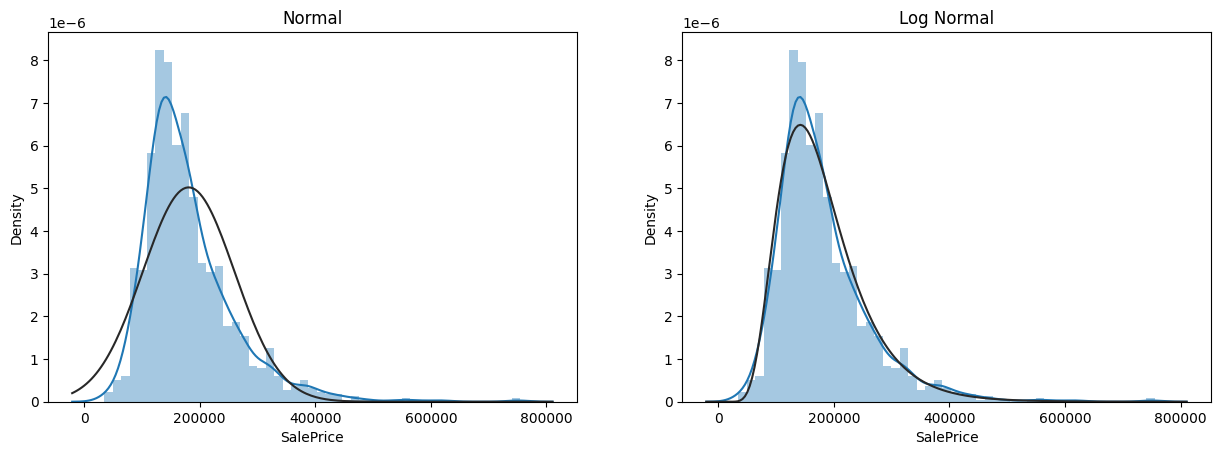

In [5]:
train["SalePrice"] = np.log1p(train["SalePrice"])
y = train.SalePrice.reset_index(drop=True)
X = train.drop(['SalePrice'], axis=1)

In [19]:
# # simplified features
# features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
# features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
# features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
# features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
# features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

# ################## ML ########################################

<div style="border: 1px solid #b3d7ff; border-radius: 8px; padding: 12px; background: #e6f2ff; color: #000000; font-size: 20px;">
  <p style="margin: 0;"><strong>Tiến hành huấn luyện mô hình</strong></p>
</div>


In [6]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)


# rmsle
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


def cv_rmse(model):
    rmse_list = []
    for train_idx, val_idx in tqdm(kfolds.split(X), total=kfolds.get_n_splits(), desc=f"CV for {model.__class__.__name__}"):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model_clone = clone(model)
        model_clone.fit(X_train, y_train)
        y_pred = model_clone.predict(X_val)

        rmse_list.append(rmsle(y_val, y_pred))
    return np.array(rmse_list)

# setup models    
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

ridge = RidgeCV(alphas=alphas_alt, cv=kfolds)

lasso = LassoCV(max_iter=int(1e7), alphas=alphas2, random_state=42, cv=kfolds)

elasticnet = ElasticNetCV(max_iter=int(1e7), alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio)

svr = SVR(C=20, epsilon=0.008, gamma=0.0003)


svr = make_pipeline(SVR(C=20, epsilon=0.008, gamma=0.0003, ))

gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                max_depth=4, max_features='sqrt',
                                min_samples_leaf=15, min_samples_split=10,
                                loss='huber', random_state=42)

lightgbm = LGBMRegressor(
    objective='regression',num_leaves=4,
    learning_rate=0.01,
    n_estimators=5000,
    max_bin=200,
    bagging_fraction=0.75,
    bagging_freq=5,
    bagging_seed=7,
    feature_fraction=0.2,
    feature_fraction_seed=7,
    verbose=-1,
    # min_data_in_leaf=2,
    # min_sum_hessian_in_leaf=11
)

xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                       max_depth=3, min_child_weight=0,
                       gamma=0, subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear', nthread=-1,
                       scale_pos_weight=1, seed=27,
                       reg_alpha=0.00006)

# stack
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet,
                                            gbr, xgboost, lightgbm),
                                            meta_regressor=xgboost,
                                            use_features_in_secondary=True)

print('TEST score on CV')

score = cv_rmse(ridge)
print("Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(elasticnet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(svr)
print("SVR score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(gbr)
print("GradientBoosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(lightgbm)
print("Lightgbm score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(xgboost)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


print('START Fit')

print('StackingCVRegressor')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

print('elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)

print('lasso')
lasso_model_full_data = lasso.fit(X, y)

print('ridge')
ridge_model_full_data = ridge.fit(X, y)

print('svr')
svr_model_full_data = svr.fit(X, y)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)

print('xgboost')
xgb_model_full_data = xgboost.fit(X, y)

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)



# def blend_models_predict(X=X):
#     return ((0.1* elastic_model_full_data.predict(X)) + 
#             (0.1 * lasso_model_full_data.predict(X)) + 
#             (0.05 * ridge_model_full_data.predict(X)) + 
#             (0.1 * svr_model_full_data.predict(X)) + 
#             (0.1 * gbr_model_full_data.predict(X)) + 
#             (0.15 * xgb_model_full_data.predict(X)) + 
#             (0.1 * lgb_model_full_data.predict(X)) + 
#             (0.3 * stack_gen_model.predict(np.array(X))))


# print('RMSLE score on train data:')
# print(rmsle(y, blend_models_predict(X)))
# print('MSE score on train data:')
# print(mean_squared_error(y, blend_models_predict(X)))
# print('MAE score on train data:')
# print(mean_absolute_error(np.expm1(y), np.floor(np.expm1(blend_models_predict(X)))))


TEST score on CV


CV for RidgeCV: 100%|██████████| 10/10 [00:13<00:00,  1.34s/it]


Ridge score: 0.1244 (0.0157)



CV for LassoCV: 100%|██████████| 10/10 [00:02<00:00,  4.03it/s]


Lasso score: 0.1223 (0.0157)



CV for ElasticNetCV: 100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


ElasticNet score: 0.1224 (0.0157)



CV for Pipeline: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


SVR score: 0.1225 (0.0184)



CV for GradientBoostingRegressor: 100%|██████████| 10/10 [01:35<00:00,  9.57s/it]


GradientBoosting score: 0.1233 (0.0182)



CV for LGBMRegressor: 100%|██████████| 10/10 [00:15<00:00,  1.54s/it]


Lightgbm score: 0.1246 (0.0153)



CV for XGBRegressor: 100%|██████████| 10/10 [00:33<00:00,  3.35s/it]


Xgboost score: 0.1206 (0.0181)

START Fit
StackingCVRegressor
elasticnet
lasso
ridge
svr
GradientBoosting
xgboost
lightgbm


In [21]:
# print('RMSLE score on train data:')
# print(rmsle(y, blend_models_predict(X)))
# print('MSE score on train data:')
# print(mean_squared_error(y, blend_models_predict(X)))
# print('MAE score on train data:')
# print(mean_absolute_error(np.expm1(y), np.floor(np.expm1(blend_models_predict(X)))))

<div style="border: 1px solid #b3d7ff; border-radius: 8px; padding: 12px; background: #e6f2ff; color: #000000; font-size: 20px;">
  <p style="margin: 0;"><strong>Predict trên tập test</strong></p>
</div>


In [7]:
print('Predict submission')
submission = pd.read_csv("/kaggle/input/home-data-for-ml-course/sample_submission.csv")

submission.iloc[:, 1] = np.floor(np.expm1(xgb_model_full_data.predict(test)))

submission.to_csv("House_price_submission.csv", index=False)
print('Save submission' )

Predict submission
Save submission


In [8]:
print('Predict submission')
submission = pd.read_csv("/kaggle/input/home-data-for-ml-course/sample_submission.csv")

submission.iloc[:, 1] = np.floor(np.expm1(elastic_model_full_data.predict(test)))

submission.to_csv("House_price_submission(elastic).csv", index=False)
print('Save submission' )

Predict submission
Save submission


In [9]:
print('Predict submission')
submission = pd.read_csv("/kaggle/input/home-data-for-ml-course/sample_submission.csv")

submission.iloc[:, 1] = np.floor(np.expm1(lasso_model_full_data.predict(test)))

submission.to_csv("House_price_submission_lasso.csv", index=False)
print('Save submission' )

Predict submission
Save submission


In [10]:
print('Predict submission')
submission = pd.read_csv("/kaggle/input/home-data-for-ml-course/sample_submission.csv")

submission.iloc[:, 1] = np.floor(np.expm1(ridge_model_full_data.predict(test)))

submission.to_csv("House_price_submission_ridge.csv", index=False)
print('Save submission' )

Predict submission
Save submission


In [11]:
print('Predict submission')
submission = pd.read_csv("/kaggle/input/home-data-for-ml-course/sample_submission.csv")

submission.iloc[:, 1] = np.floor(np.expm1(svr_model_full_data.predict(test)))

submission.to_csv("House_price_submission_svr.csv", index=False)
print('Save submission' )

Predict submission
Save submission


In [12]:
print('Predict submission')
submission = pd.read_csv("/kaggle/input/home-data-for-ml-course/sample_submission.csv")

submission.iloc[:, 1] = np.floor(np.expm1(gbr_model_full_data.predict(test)))

submission.to_csv("House_price_submission_gbr.csv", index=False)
print('Save submission' )

Predict submission
Save submission


In [13]:
print('Predict submission')
submission = pd.read_csv("/kaggle/input/home-data-for-ml-course/sample_submission.csv")

submission.iloc[:, 1] = np.floor(np.expm1(lgb_model_full_data.predict(test)))

submission.to_csv("House_price_submission_lgb.csv", index=False)
print('Save submission' )

Predict submission
Save submission
